In [3]:
from pathlib import Path
import os
import shutil
import cv2

import glob
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

HOME = os.getcwd()
ROOT = str(Path.home())
DIR_FINGERS = os.path.join(HOME, 'Fingers_data','fingers')
TARGET_SIZE = (128,128)


In [3]:
def mkdir(path):
  try:
    os.makedirs(path, exist_ok=True)
  except:
    print("Folder already exists. Passing.")
    pass
     

def copy(From, to):
  if not os.path.isdir(to):
    os.mkdir(to)
  if os.path.isfile(From):
    shutil.copy(From, to)
  else:
    files = sorted(os.listdir(From))
    for f in files:
      shutil.copy(f'{From}/{f}', to)
     

def remove_files(path):
  for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    try:
        if os.path.isfile(file_path):
            os.remove(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
     

def count_files(path):
  return len(next(os.walk(path))[2])

def show_image(path):
  img = cv2.imread(path)
  print(img.shape)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def rename_data(partition_path):
  "somehow it works only first time"
  path = os.path.join(DIR_FINGERS, partition_path)
  i = 0
  for file in sorted(glob.glob(os.path.join(path, '*'))):
    name = file.split(".png")[0][-2:]
    os.rename(file,os.path.join(path,f"{name[0]}_{name[1]}_{i}.png"))
    i += 1


Renaming Images : {fingerNo}_ {hand} _{fileNo}

16036 train + 3600 test = Total of 19636 images


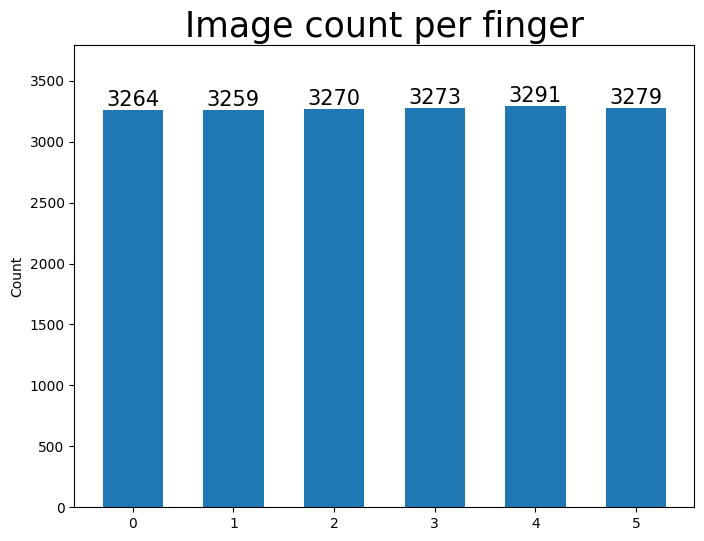

In [31]:
def count_fingers():
  counts = [0,0,0,0,0,0]

  totals = []
  for partition in ['train','test']:
    total = 0
    for file in glob.glob(os.path.join(DIR_FINGERS, partition, '*')):
      count = int(file.split(os.path.sep)[-1][0]) 
      counts[count] += 1
      total += 1
    totals.append(total)

  plt.figure(figsize=(8, 6))
  bar = plt.bar([0, 1, 2, 3, 4, 5], height=counts, data=counts, align='center', width=0.6)
  plt.ylim(0, max(counts)+500)
  plt.ylabel('Count')
  plt.title('Image count per finger', fontsize=25)

  for rect in bar:
      height = rect.get_height()
      plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom', fontsize=15)

  print(f'{totals[0]} train + {totals[1]} test = Total of {sum(totals)} images')


In [33]:

def check_dimen():
    shapes = {}
    i = 0

    for partition in ['train', 'test']:
        for file in glob.glob(os.path.join(DIR_FINGERS, partition, '*')):
            img = cv2.imread(file, 0)
            shape = img.shape
            if shape not in shapes.values():
                i += 1
                shapes.update({i: shape})
    print(shapes)
    if len(shapes) == 1:
        print(f"All images' shapes are equal to {img.shape}.")
    else:
  raise ValueError('Something went wrong. Check the dimensions.')

{1: (128, 128)}
All images' shapes are equal to (128, 128).


Making DataSet

In [31]:
import os
from keras.preprocessing.image import  array_to_img, img_to_array, load_img

def prepare_dataset(folder):
  data = []
  labels = []

  for partition in os.listdir(folder):
    for file in sorted(glob.glob(os.path.join(folder, partition, '*'))):
      current_img = cv2.imread(file, 0)
      current_img = img_to_array(current_img)
      data.append(current_img)
      label = int(file.split(os.path.sep)[-1][0])
      labels.append(label)
  return data, labels


def normalize(data, labels):
  data = np.array(data, dtype="float") / 255.0
  labels = np.array(labels)
  return data, labels

data,label  = prepare_dataset(DIR_FINGERS)


In [32]:
data,label = normalize(data,label)

In [33]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


(x_train, x_test, y_train, y_test) = train_test_split(data,
	label, test_size=0.2, random_state=1)



y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



In [34]:
print ("number of training examples = " + str(x_train.shape[0]))
print ("number of test examples = " + str(x_test.shape[0]))
print ("X_train shape: " + str(x_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(x_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 15708
number of test examples = 3928
X_train shape: (15708, 128, 128, 1)
Y_train shape: (15708, 6)
X_test shape: (3928, 128, 128, 1)
Y_test shape: (3928, 6)


In [22]:
import h5py
with h5py.File("fingers_dataset.hdf5", "w") as f:
  f.create_dataset('x_train_fingers_dataset', data=x_train)
  f.create_dataset('y_train_fingers_dataset', data=y_train)
  f.create_dataset('x_test_fingers_dataset', data=x_test)
  f.create_dataset('y_test_fingers_dataset', data=y_test)




In [35]:
idg = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=30,
    shear_range = 0.2,
    width_shift_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.2,fill_mode="nearest"
    )





MODELING

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam


2024-07-31 09:23:30.268141: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 09:23:31.577950: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 09:23:32.440767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 09:23:33.225498: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 09:23:33.487355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 09:23:35.251246: I tensorflow/core/platform/cpu_feature_gu

In [5]:
BATCH_SIZE = 60
EPOCHS = 30
LEARNING_RATE = 1e-3
     

In [19]:
def create_model():
  model = Sequential()
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', 
                  input_shape=(TARGET_SIZE[1], TARGET_SIZE[0], 1), #accepts (128,128)
                  use_bias=False))
            
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', use_bias=False))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', use_bias=False))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', use_bias=False))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dropout(0.5))
  model.add(Dense(512, activation='relu', use_bias=False))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(128, activation='relu', use_bias=False))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.add(Dense(6, activation='softmax', use_bias=False)) # output layer with 6 neurons
  return model


In [27]:
my_model = create_model()
# my_model.summary()
my_model.compile(loss=categorical_crossentropy,optimizer= 'Adam',metrics=['mae'])
my_model.summary()

/mnt/5D92528E6B945467/Projects/python/newv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 126, 126, 64)   │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 126, 126, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 61, 61, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 28, 28, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 12, 12, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │     4,718,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        65,536 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,195,584 (19.82 MB)

 Trainable params: 5,193,280 (19.81 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [36]:

history = my_model.fit(idg.flow(x_train, y_train, batch_size=BATCH_SIZE),
	validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BATCH_SIZE,
	epochs=EPOCHS, verbose=1)


Epoch 1/30


/mnt/5D92528E6B945467/Projects/python/newv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


261/261 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - loss: 1.6178 - mae: 0.1977 - val_loss: 44.6950 - val_mae: 0.2772
Epoch 2/30
  1/261 ━━━━━━━━━━━━━━━━━━━━ 5:42 1s/step - loss: 0.6580 - mae: 0.1208

2024-07-31 09:45:37.395181: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


261/261 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 0.6580 - mae: 0.1208 - val_loss: 44.2299 - val_mae: 0.2772
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 357s 1s/step - loss: 0.4406 - mae: 0.0869 - val_loss: 2322.6685 - val_mae: 0.2772
Epoch 4/30
  1/261 ━━━━━━━━━━━━━━━━━━━━ 5:35 1s/step - loss: 0.2005 - mae: 0.0472

2024-07-31 09:51:46.960814: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


261/261 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 0.2005 - mae: 0.0472 - val_loss: 2326.1208 - val_mae: 0.2772
Epoch 5/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - loss: 0.2593 - mae: 0.0524 - val_loss: 8153.2051 - val_mae: 0.2772
Epoch 6/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 0.1683 - mae: 0.0303 - val_loss: 8305.3223 - val_mae: 0.2772
Epoch 7/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - loss: 0.1829 - mae: 0.0370 - val_loss: 15090.8857 - val_mae: 0.2772
Epoch 8/30
  1/261 ━━━━━━━━━━━━━━━━━━━━ 5:39 1s/step - loss: 0.0937 - mae: 0.0195

2024-07-31 10:03:54.721728: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


261/261 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - loss: 0.0937 - mae: 0.0195 - val_loss: 14933.3760 - val_mae: 0.2772
Epoch 9/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - loss: 0.1468 - mae: 0.0295 - val_loss: 18470.8750 - val_mae: 0.2772
Epoch 10/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 0.1200 - mae: 0.0293 - val_loss: 18499.0762 - val_mae: 0.2772
Epoch 11/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 350s 1s/step - loss: 0.1219 - mae: 0.0236 - val_loss: 14007.2617 - val_mae: 0.2772
Epoch 12/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 0.0546 - mae: 0.0135 - val_loss: 13809.5430 - val_mae: 0.2772
Epoch 13/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 351s 1s/step - loss: 0.1054 - mae: 0.0201 - val_loss: 16307.1250 - val_mae: 0.2772
Epoch 14/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - loss: 0.0376 - mae: 0.0102 - val_loss: 16352.7061 - val_mae: 0.2772
Epoch 15/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - loss: 0.0897 - mae: 0.0166 - val_loss: 16461.5352 - val_mae: 0.2772
Epoch 16/30
  1/2

2024-07-31 10:28:09.711137: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


261/261 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 0.0344 - mae: 0.0100 - val_loss: 16593.6582 - val_mae: 0.2772
Epoch 17/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - loss: 0.0677 - mae: 0.0135 - val_loss: 14883.3525 - val_mae: 0.2772
Epoch 18/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 0.0583 - mae: 0.0136 - val_loss: 14725.7314 - val_mae: 0.2772
Epoch 19/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 353s 1s/step - loss: 0.0803 - mae: 0.0141 - val_loss: 17195.0898 - val_mae: 0.2772
Epoch 20/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 0.0911 - mae: 0.0094 - val_loss: 16733.0586 - val_mae: 0.2772
Epoch 21/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - loss: 0.0699 - mae: 0.0125 - val_loss: 13360.5801 - val_mae: 0.2772
Epoch 22/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 0.0339 - mae: 0.0093 - val_loss: 13734.7051 - val_mae: 0.2772
Epoch 23/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 354s 1s/step - loss: 0.0568 - mae: 0.0105 - val_loss: 17349.5762 - val_mae: 0.2772
Epoch 24/30
261/

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=fingers_recon.model.

In [37]:

# my_model.save("fingers_recon.keras")

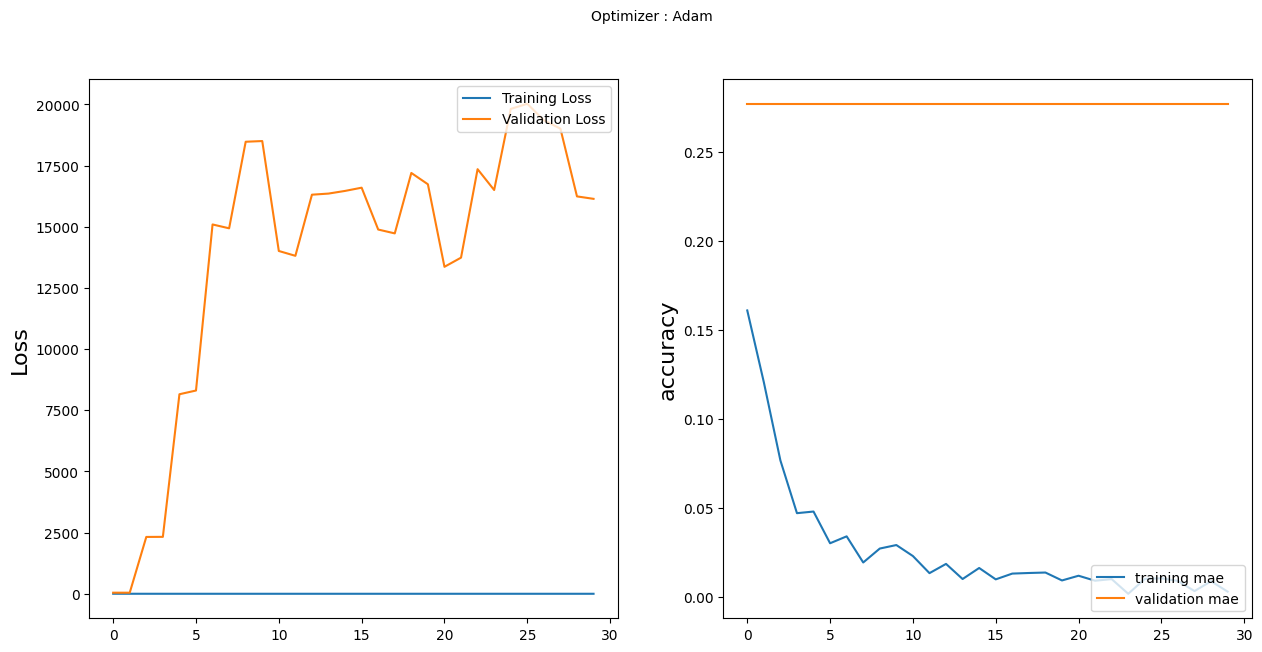

In [42]:

plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

# plt.subplot(1, 2, 2)
# plt.ylabel('Accuracy', fontsize=16)
# plt.plot(history.history['acc'], label='Training Accuracy')
# plt.plot(history.history['val_acc'], label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.show()
plt.subplot(1,2,2)
plt.ylabel('accuracy',fontsize=16)
plt.plot(history.history["mae"],label='training mae')
plt.plot(history.history["val_mae"],label="validation mae")
plt.legend(loc='lower right')
plt.show()

In [50]:
from tensorflow.keras.models import load_model
from keras.preprocessing.image import  array_to_img, img_to_array, load_img

def evaluate(file, label):
  data, labels = [[]]*2
  # img = cv2.imread(file) # returns a numpy array 
  # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # gray = cv2.resize(gray, TARGET_SIZE)
  # cv2.imwrite(file, gray)

  img = cv2.imread(file, 0)
  img = img_to_array(img)
  img = img[:, :, 0] # for converting 3d array into 2d 
  print("after reducing " + str(img.shape) ) 
  data.append(img)
  label = str(label)
  labels.append(label)
  for da in data:
    print(da)
  plt.imshow(data[0])

  # data = np.array(data,dtype="float") /255.0
  # data = np.array(data[0], dtype="float") / 255.0
  labels = np.array(labels)
  model = load_model("fingers_recon.keras")
  pred = model.evaluate(img,
                      label,
                      batch_size = 128)
  
  print("Accuracy of model on test data is: ", pred[1]*100)

after reducing (128, 128)
[[255. 255. 255. ... 251. 255. 255.]
 [255. 255. 255. ... 253. 253. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [248. 253. 253. ... 255. 255. 255.]
 [252. 254. 255. ... 255. 255. 255.]
 [255. 254. 255. ... 255. 255. 255.]]
3


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

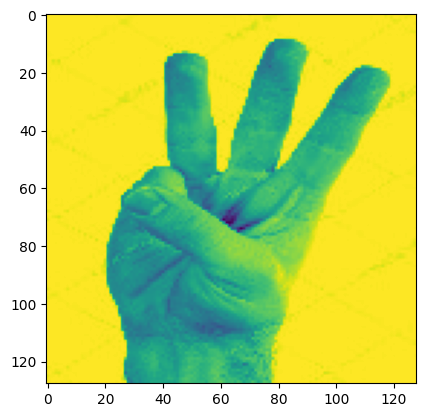

In [51]:
# for f in sorted(glob.glob(os.path.join("evaluate", '*'))):
#   evaluate(f, f.split(os.path.sep)[-1][0])
  
evaluate("three_fingers.jpg",3)
